In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time

from matplotlib import pyplot as plt

from assembly_gym.envs.assembly_env import AssemblyEnv, Shape, Block
from assembly_gym.envs.gym_env import AssemblyGym, sparse_reward, tower_setup, bridge_setup, hard_tower_setup, Action

from assembly_gym.utils import align_frames_2d
from assembly_gym.utils.rendering import plot_assembly_env, render_assembly_env, plot_block_movements, plot_cra_assembly

pybullet build time: May 28 2024 09:55:49


# The Assembly Environment

The assembly environment is a wrapper around the pybullet physics engine. It provides a simple interface to add blocks and obstacles to the environment.

The basic element is defined by `Shape` which loads the geometry from a urdf file. The `Shape` class provides an interface to compute relative coordinates for each of the faces or edges in 2d.
A `Block` is defined by a `Shape` and a position and orientation in 3d space.

In [2]:
# load shapes
trapezoid = Shape(urdf_file='shapes/trapezoid.urdf')
vblock = Shape(urdf_file='shapes/v_block.urdf')
cube = Shape(urdf_file='shapes/cube.urdf')
# cube = Shape(urdf_file='shapes/small_cube.urdf')
tblock = Shape(urdf_file='shapes/t_block.urdf')

trapezoid.num_faces_2d, trapezoid.urdf_file

(4,
 '/Users/johannes/SDSC/Projects/Robotoddler/robotoddler-dev/assembly_gym/assembly_gym/../shapes/trapezoid.urdf')

In [3]:
# stability checks performed by the environment
# stability_checks = ('pybullet')  # previous default
# stability_checks = ('cra', 'cra_penalty', 'pybullet')  # adding two new checks based on cra
stability_checks = ('rbe', 'pybullet')  # rbe check as default and pybullet computed in addition

env = AssemblyEnv(render=True, bounds=np.array([[-5., -5., -1], [5., 5., 10.]]), stability_checks=stability_checks)

argv[0]=
Version = 4.1 Metal - 88.1
Vendor = Apple
Renderer = Apple M2 Pro
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


## add one block and visualize the contact points


{'last_block': Block (1), 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': None, 'pybullet_stable': False, 'pybullet_initial_state': [((-1.0, -0.5, 0.0), Quaternion(1.0, 0.0, 0.0, 0.0))], 'pybullet_final_state': [((-1.000231983366777, -0.5001546198649026, 0.0009899999999991164), Quaternion(0.9902973736439321, 0.07708751136234272, -0.11562275559526622, 7.572614014284595e-05))], 'rbe_stable': True, 'stable': True}


Text(0.5, 1.0, 'CRA Assembly')

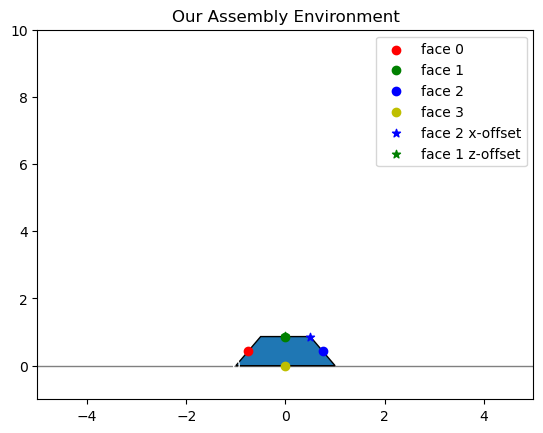

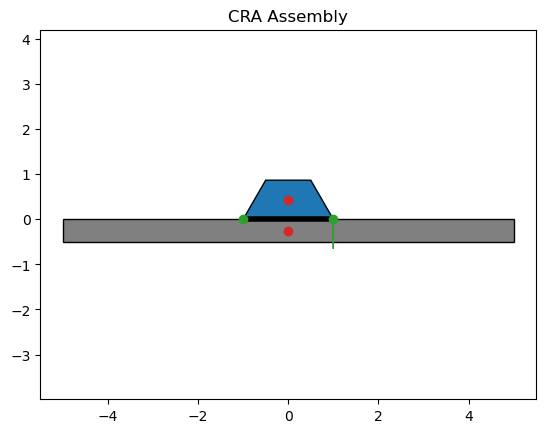

In [4]:
env.reset()
shape = trapezoid

# place first block on floor
position, rotation = align_frames_2d(env.get_floor_frame(), shape.get_face_frame_2d(face=3), frame1_coordinates=[0, 0, 0])

block1 = Block(shape=shape, position=position, orientation=rotation.quaternion)
print(env.add_block(block1))
fig, ax = plot_assembly_env(env)


colors = ['r', 'g', 'b', 'y']
# plot contact point for all faces
for i in range(4):
    frame = block1.get_face_frame_2d(face=i)
    contact_point = frame.to_world_coordinates([0.0, 0, 0])
    ax.scatter([contact_point[0]], [contact_point[2]], label=f'face {i}', color=colors[i])

# shift the contact point  in frame coordinates
frame = block1.get_face_frame_2d(face=2)
contact_point = frame.to_world_coordinates([-0.5, 0, 0])
ax.scatter([contact_point[0]], [contact_point[2]], marker='*', label=f'face 2 x-offset', color=colors[2])

frame = block1.get_face_frame_2d(face=1)
contact_point = frame.to_world_coordinates([0.0, 0, 0.01])
ax.scatter([contact_point[0]], [contact_point[2]], marker='*', label=f'face 1 z-offset', color=colors[1])

ax.legend()
ax.set_title("Our Assembly Environment")
# env.client.resetDebugVisualizerCamera(cameraDistance=0.5, cameraYaw=0, cameraPitch=-40, cameraTargetPosition=[0.2,0,0])

fig, ax = plot_cra_assembly(env.assembly, plot_forces=True, plot_edges=False, force_scale=10)
ax.set_title("CRA Assembly")

In [5]:
env.blocks

[Block (1)]

In [6]:
# set pybullet camera


1
{'last_block': Block (1), 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': None, 'pybullet_stable': False, 'pybullet_initial_state': [((-1.0, -0.5, 0.0), Quaternion(1.0, 0.0, 0.0, 0.0))], 'pybullet_final_state': [((-1.000231983366777, -0.5001546198649026, 0.0009899999999991164), Quaternion(0.9902973736439321, 0.07708751136234272, -0.11562275559526622, 7.572614014284595e-05))], 'rbe_stable': True, 'stable': True, 'frozen': 0}


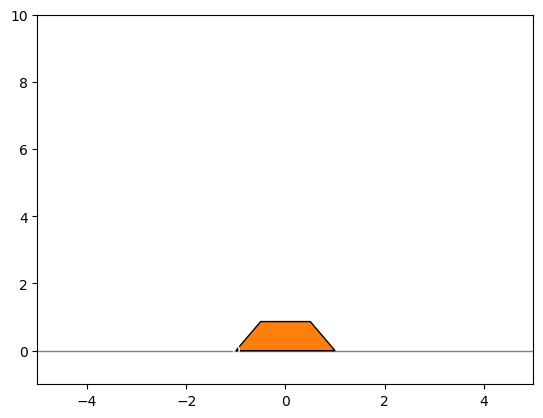

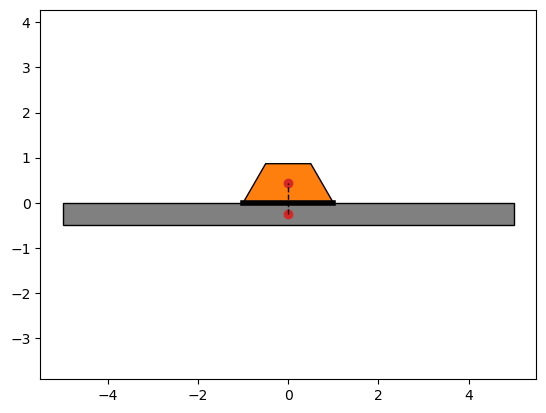

In [7]:
print(env.freeze_block(len(env.blocks)-1))
plot_assembly_env(env)
plot_cra_assembly(env.assembly, plot_forces=False, plot_edges=True, force_scale=1000)
print(env.state_info)

{'last_block': Block (1), 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': None, 'pybullet_stable': False, 'pybullet_initial_state': [((-1.0, -0.5, 0.0), Quaternion(1.0, 0.0, 0.0, 0.0))], 'pybullet_final_state': [((-1.000231983366777, -0.5001546198649026, 0.0009899999999991164), Quaternion(0.9902973736439321, 0.07708751136234272, -0.11562275559526622, 7.572614014284595e-05))], 'rbe_stable': True, 'stable': True, 'frozen': 0}


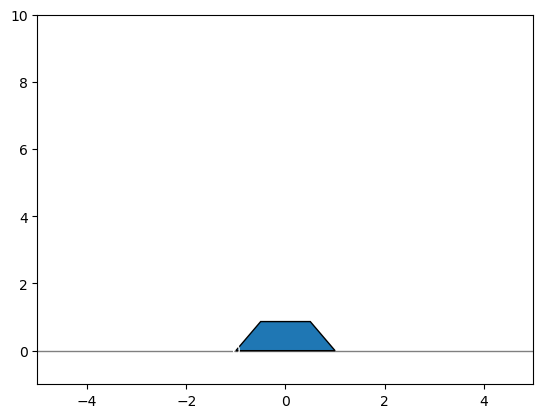

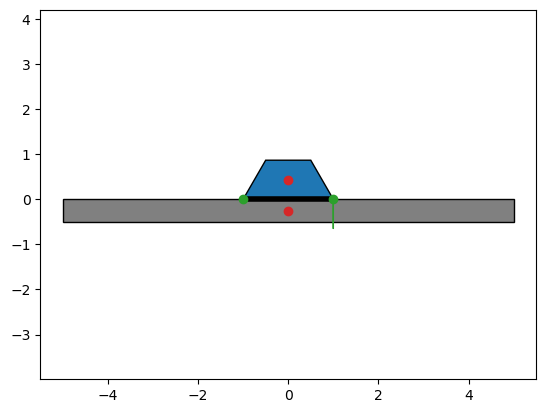

In [8]:
env.unfreeze_block()
plot_assembly_env(env)
plot_cra_assembly(env.assembly, plot_forces=True, plot_edges=False, force_scale=10)
print(env.state_info)

# next, we are adding two obstacles and two more blocks

    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.14.16\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
{'last_block': Block (1), 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': None, 'pybullet_stable': False, 'pybullet_initial_state': [((-1.0, -0.5, 0.0), Quaternion(1.0, 0.0, 0.0, 0.0)), ((1.0000000201917607, -0.5000000000000002, 2.5980761880378793), Quaternion(0.4999999966347066, 2.2412592282597874e-17, 0.8660254057273917, 2.2412592282597874e-17))], 'pybullet_final_state': [((-1.000001162328833, -0.4999964631537098, 0.000989999999999368), Quaternion(0.9999999993092886, 2.124566265989424e-08, -3.716498711453049e-05, -4.3129924749338973e-07)), ((3.1607216924741506, -0.6529517052212799, 0.00098999999999915), Quaternion(0.5617273389453834, 0.12406387887957146, -0.8135044715908646, 0.08532892440645079))], 'rbe_stable': False, 

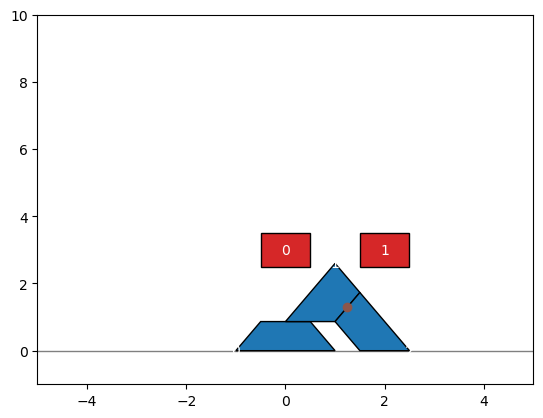

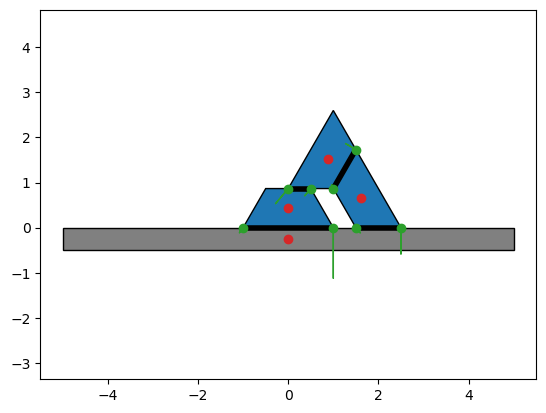

In [9]:
# add obstacles (shift them to create a collision)
env.add_obstacle(Block(shape=cube, position=[0, 0.0, 3]))
env.add_obstacle(Block(shape=cube, position=[2, 0.0, 3]))

# add second block
position, rotation = align_frames_2d(block1.get_face_frame_2d(face=1), trapezoid.get_face_frame_2d(face=2), frame1_coordinates=[0.5, 0., 0.])
block2 = Block(shape=trapezoid, position=position, orientation=rotation.quaternion)
print(env.add_block(block2))


# add third block
#contact point of block 2 (just for plotting):
p2 = block2.get_face_frame_2d(1).to_world_coordinates([-0.0, 0, 0])
position, rotation = align_frames_2d(block2.get_face_frame_2d(face=1), trapezoid.get_face_frame_2d(face=2), frame1_coordinates=[-0.0, 0.0, 0])
# position, rotation = align_frames_2d(env.get_floor_frame(), trapezoid.get_face_frame_2d(2), frame1_coordinates=[0.2, 0.0, 0])
block3 = Block(shape=trapezoid, position=position, orientation=rotation.quaternion)
print(env.add_block(block3))

# # add another block on the floor, in a collision position
# position, rotation = align_frames_2d(env.get_floor_frame(), trapezoid.get_face_frame_2d(face=2), frame1_coordinates=[0.45, 0.0, -0.01])
# block4 = Block(base_block=trapezoid, position=position, orientation=rotation.quaternion)
# print(env.add_block(block4))

fig, ax = plot_assembly_env(env)
ax.scatter([p2[0]], [p2[2]])

fig, ax = plot_cra_assembly(env.assembly, plot_forces=True, plot_edges=False, force_scale=10)

In [10]:
env.restore()
# env.client.resetDebugVisualizerCamera(cameraDistance=0.5, cameraYaw=0, cameraPitch=-40, cameraTargetPosition=[0.2,0,0])

In [12]:
# simulate the environment

env.restore()
time.sleep(1)
env.restore()
# start_time = time.time()
# max_time = 3
# while True:
#     env.realtime()
#     if time.time() - start_time > max_time:
#         break

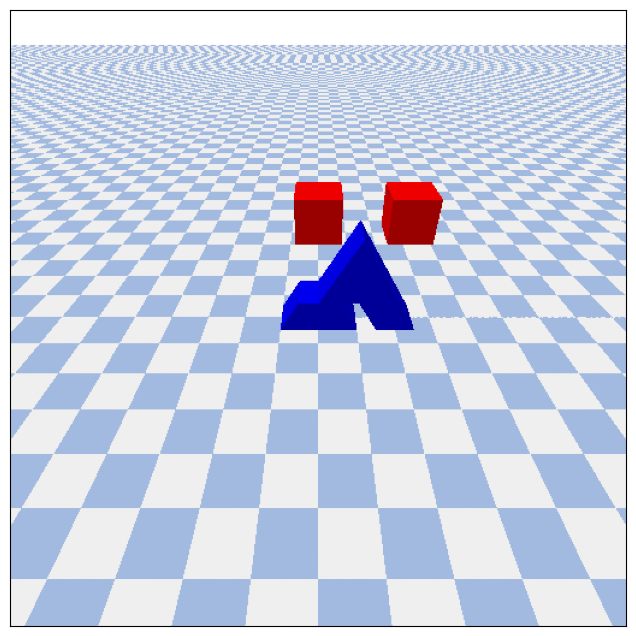

In [10]:
# render 3d view
fig, ax = render_assembly_env(near=0.1, fov=80, far=100, target=[0.0, 0, 0], distance=10.)

In [11]:
#  disconnect
env.disconnect_client()

# 2 AssemblyGym

The `AssemblyGym` class is a gym environment based on the `AssemblyEnv`.
It is defined by a set of available shapes, a set of obstacles, a set of targets, and a reward function.

## Tower setup

argv[0]=


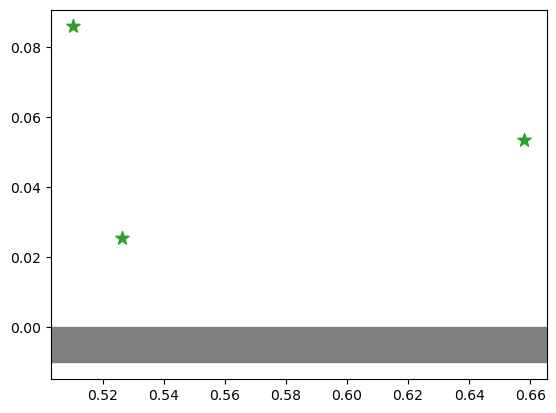

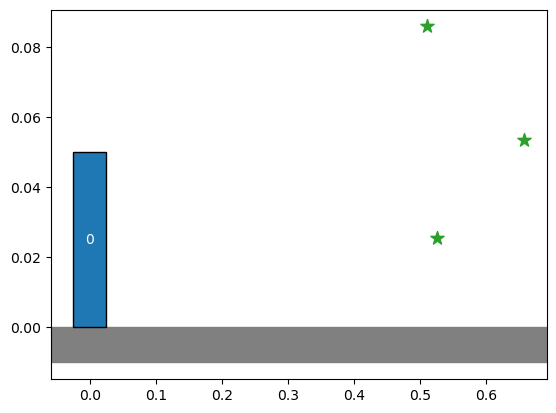

In [10]:
env = AssemblyGym(**tower_setup(), 
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False))
plot_assembly_env(env)

action = Action(-1, 1,0,0, 0, 0)

obs, _, _, _, info = env.step(action)
plot_assembly_env(env)

env.assembly_env.disconnect_client()

## Bridge Setup

argv[0]=


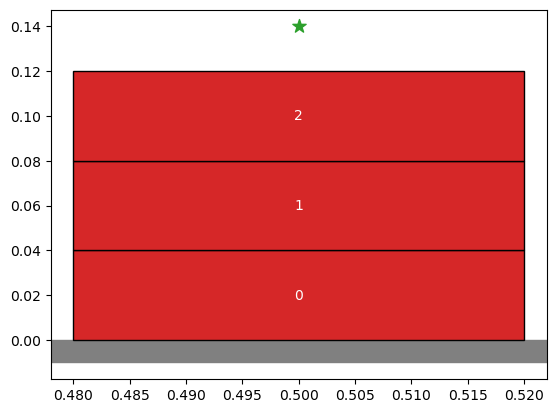

In [11]:
env = AssemblyGym(**bridge_setup(num_stories=3), 
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False, 
                                           stability_checks=stability_checks))
plot_assembly_env(env)
env.assembly_env.client.resetDebugVisualizerCamera(cameraDistance=0.5, cameraYaw=0, cameraPitch=-40, cameraTargetPosition=[0.2,0,0])

## Bridge Demonstration

argv[0]=
Stable: 1, Frozen Block: None, Collision: 0, Targets Reached: 0
Reward: -1, Terminated: False, Truncated: None
--------------------------------------------------
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.14.16\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Stable: 0, Frozen Block: None, Collision: 0, Targets Reached: 0
Reward: -1, Terminated: True, Truncated: None
--------------------------------------------------
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.14.16\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Stable: 0, Frozen Block: None, Collision: 0, Targets Reached: 0
Reward: -1, Terminated: True, Truncated: None
--------------------------------------------------
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.14.16\x3a Converged 

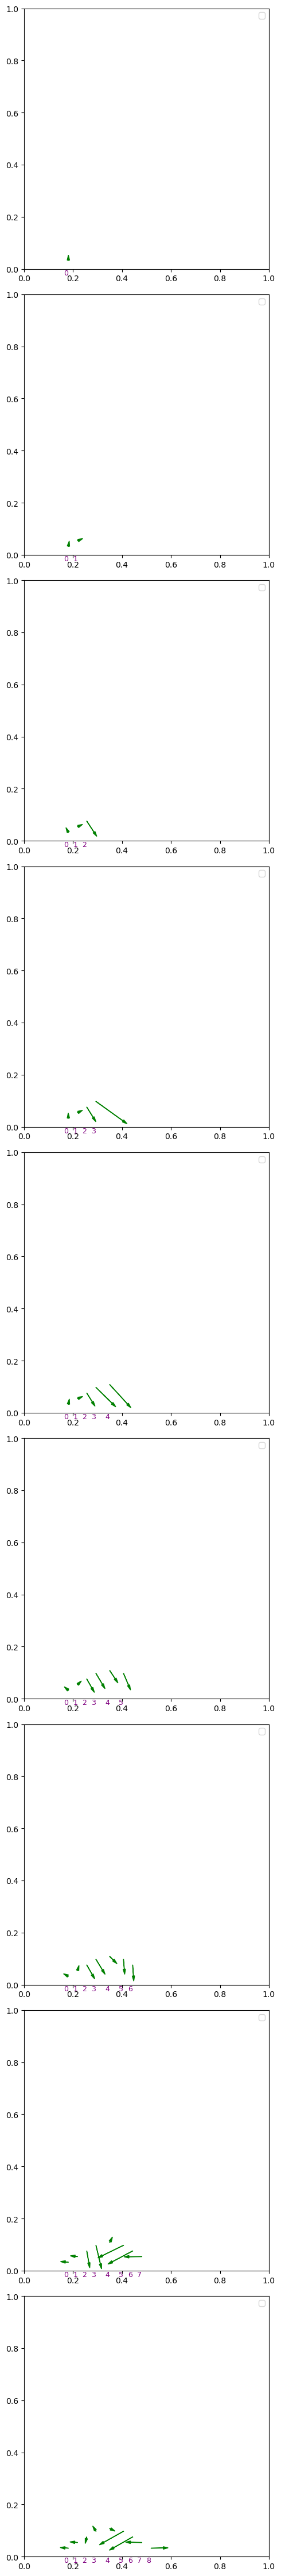

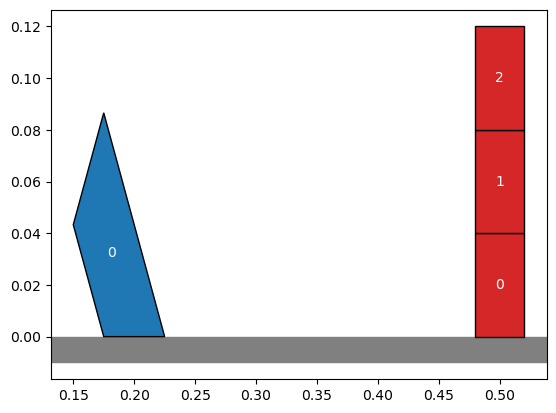

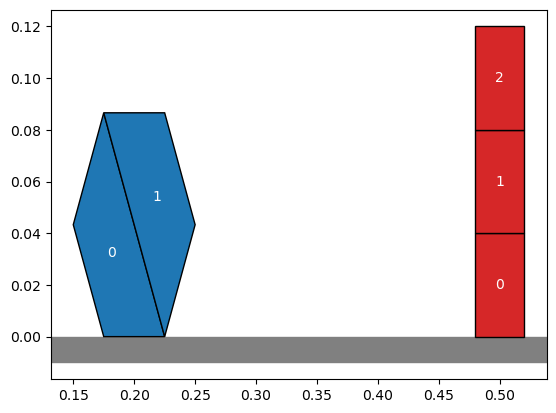

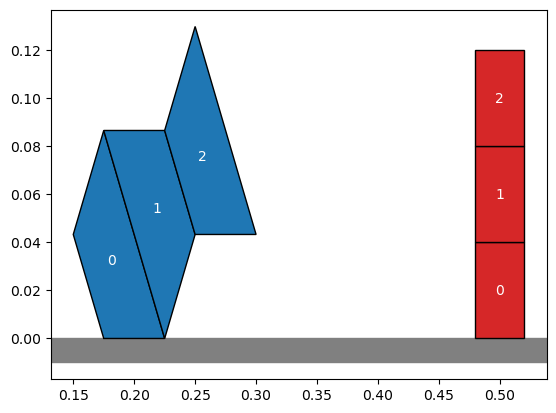

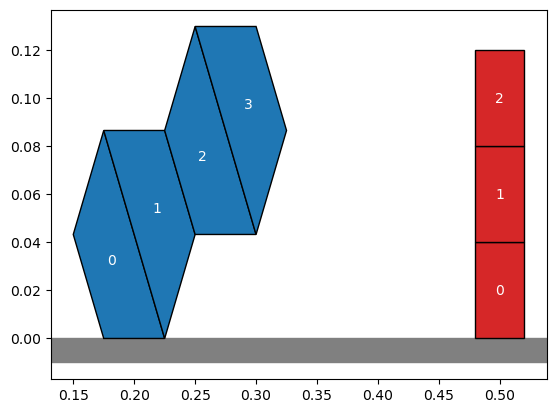

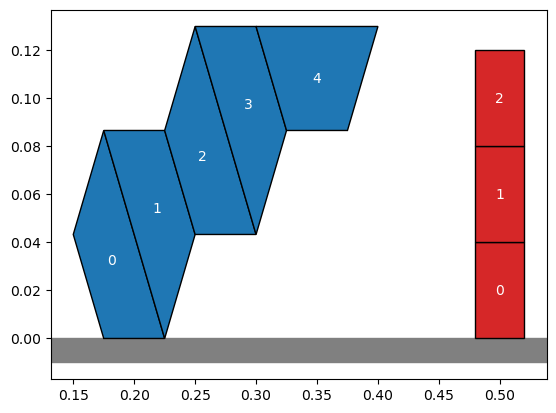

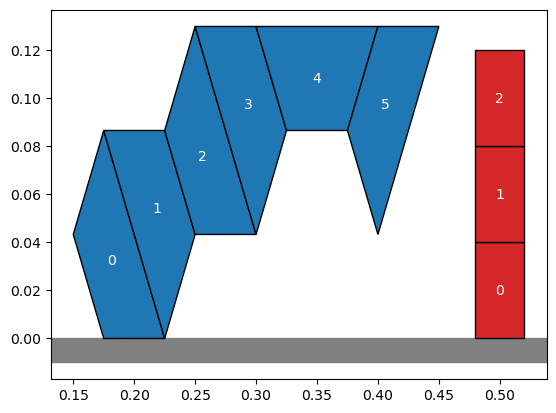

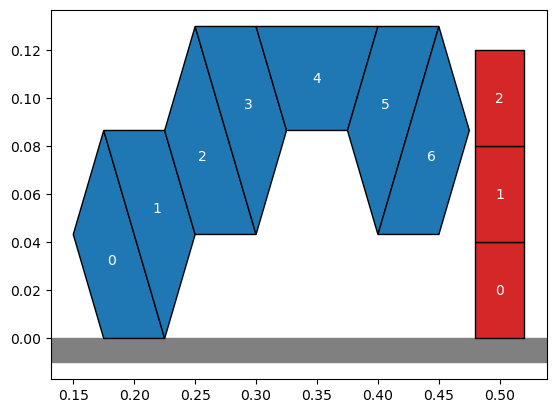

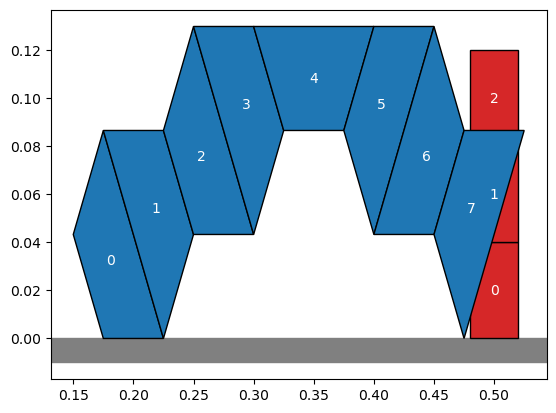

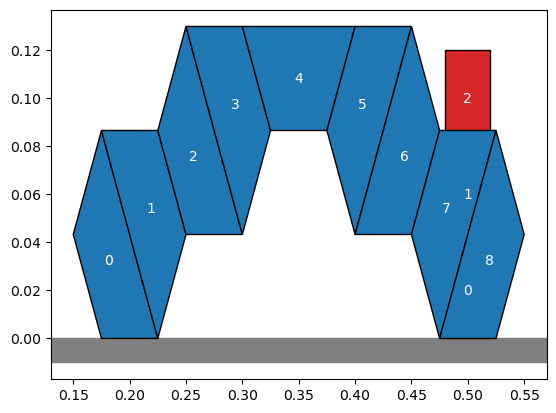

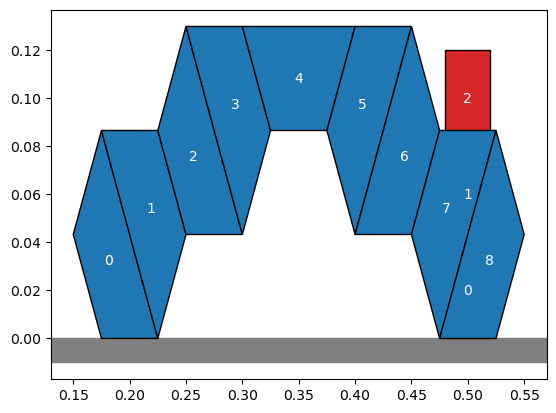

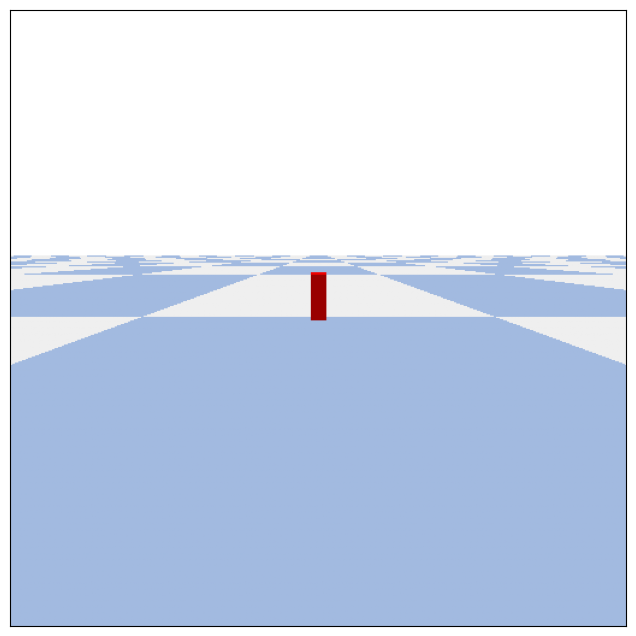

In [13]:
def print_step_info(obs, reward, terminated, truncated, info):
    # Print stable, frozen, collision, and targets reached in one line
    print(f"Stable: {obs['stable']}, Frozen Block: {obs['frozen_block']}, Collision: {obs['collision']}, Targets Reached: {len(obs['targets_reached'])}")
    
    # Print reward and termination in the next lines
    print(f"Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}")
    print("--------------------------------------------------")


env = AssemblyGym(**bridge_setup(num_stories=3), 
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False, 
                                           stability_checks=('rbe', 'pybullet' )))
env.reset()

fig, axes = plt.subplots(9,1,  figsize=(5, 9*5))

actions = [
    Action(target_block=-1, target_face=0, shape=0, face=0, offset_x=0.2, offset_y=0),
    Action(target_block=0, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
    Action(target_block=1, target_face=1, shape=0, face=1, offset_x=0, offset_y=0),
    Action(target_block=2, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
    Action(target_block=3, target_face=1, shape=0, face=2, offset_x=0, offset_y=0),
    Action(target_block=4, target_face=0, shape=0, face=1, offset_x=0, offset_y=0),
    Action(target_block=5, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
    Action(target_block=6, target_face=1, shape=0, face=1, offset_x=0, offset_y=0),
    Action(target_block=7, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
]

fig.tight_layout()

for action, axis in zip(actions, axes.T):
    obs, reward, terminated, trunated, info = env.step(action)
    plot_assembly_env(env.assembly_env)
    plot_block_movements(info["blocks_initial_state"], info["blocks_final_state"], env.assembly_env.bounds, fig=fig, ax=axis)
    print_step_info(obs, reward, terminated, trunated, info)

fig.subplots_adjust()

plot_assembly_env(env.assembly_env)

env.assembly_env.simulate()
render_assembly_env(target=(0.5, 0, 0), pitch=-20)
env.assembly_env.reset()

## Hard Tower Setup

argv[0]=


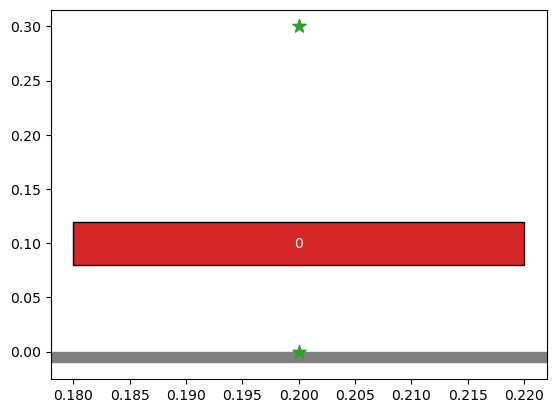

In [14]:
# create a new environment
env = AssemblyGym(**hard_tower_setup(),
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False, stability_checks=('cra_penalty', 'cra', 'pybullet')))
plot_assembly_env(env)
env.assembly_env.client.resetDebugVisualizerCamera(cameraDistance=0.5, cameraYaw=0, cameraPitch=-40, cameraTargetPosition=[0.2,0,0])

({'blocks': [Block (2)], 'stable': 1, 'collision': 0, 'collision_block': False, 'collision_obstacle': False, 'collision_floor': False, 'collision_boundary': False, 'frozen_block': None, 'obstacles': [[0.2, 0, 0.1]], 'obstacle_blocks': [Block (1)], 'targets': [[0.2, 0, 0], [0.2, 0, 0.3]], 'targets_remaining': [[0.2, 0, 0.3]], 'targets_reached': [[0.2, 0, 0]], 'distance_to_targets': [0.0, 0.24999999925494193]}, 0, False, None, {'blocks_initial_state': [((0.2, 0.0, 0.02500000037252903), Quaternion(0.7071067811865476, 0.0, -0.7071067811865475, 0.0))], 'blocks_final_state': [((0.20000086280647317, -1.1267323801370412e-08, 0.025990087327376746), Quaternion(0.7071185105563637, 1.5468321907077197e-07, -0.7070950516221279, -1.6099502107064926e-07))]})


(<Figure size 640x480 with 1 Axes>, <Axes: >)

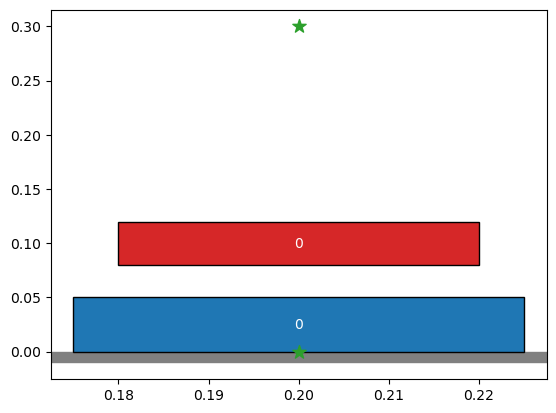

In [15]:
action = Action(-1, 0, 1, 0, 0.2, 0)

print(env.step(action))
plot_assembly_env(env)



In [16]:
print(env.step(Action(target_block=-1, target_face=0, shape=1, face=0, offset_x=0.14, offset_y=0)))
print(env.step(Action(target_block=-1, target_face=0, shape=1, face=0, offset_x=0.26, offset_y=0)))

print(env.step(Action(target_block=1, target_face=2, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=2, target_face=2, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=3, target_face=2, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=4, target_face=2, shape=1, face=0, offset_x=0., offset_y=0)))

# trapezoid
print(env.step(Action(target_block=5, target_face=2, shape=0, face=3, offset_x=0.06, offset_y=0)))

print(env.step(Action(target_block=7, target_face=1, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=8, target_face=2, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=9, target_face=2, shape=1, face=0, offset_x=0., offset_y=0)))

plot_assembly_env(env)

({'blocks': [Block (3), Block (2)], 'stable': 1, 'collision': 0, 'collision_block': False, 'collision_obstacle': False, 'collision_floor': False, 'collision_boundary': False, 'frozen_block': None, 'obstacles': [[0.2, 0, 0.1]], 'obstacle_blocks': [Block (1)], 'targets': [[0.2, 0, 0], [0.2, 0, 0.3]], 'targets_remaining': [[0.2, 0, 0.3]], 'targets_reached': [[0.2, 0, 0]], 'distance_to_targets': [0.0, 0.24999999925494193]}, 0, False, None, {'blocks_initial_state': [((0.2, 0.0, 0.02500000037252903), Quaternion(0.7071067811865476, 0.0, -0.7071067811865475, 0.0)), ((0.14, 0.0, 0.02500000037252903), Quaternion(0.7071067811865476, 0.0, -0.7071067811865475, 0.0))], 'blocks_final_state': [((0.20000086280647317, -1.1267323801370412e-08, 0.025990087327376746), Quaternion(0.7071185105563637, 1.5468321907077197e-07, -0.7070950516221279, -1.6099502107064926e-07)), ((0.14000060667519515, -5.849382830462744e-09, 0.02599006175729402), Quaternion(0.7071150296683649, 8.007507661401742e-08, -0.7070985326085

IndexError: index (53) out of range

In [17]:
env.assembly_env.disconnect_client()